In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')
from graph_utils import save_mpl_fig

FP_NYT = '../data/nyt_1987_2007_textstat.csv.gz'
FP_CNN = '../data/cnn_2000_2021_textstat.csv.gz'
FP_NPR = '../data/npr_cnn_textstat.csv.gz'
FP1_MSNBC = '../data/msnbc2003_2014_textstat.csv.gz'
FP2_MSNBC = '../data/msnbc2010_2021_textstat.csv.gz'
SAVEPATH = '../figs/'

In [2]:
# (fold cell) Prep NYT
df_nyt = (pd.read_csv(FP_NYT, usecols=['date', 'terms', 'flesch_reading_ease', 'mtld'])
          .rename(columns={'Publication Date': 'date'})
          .assign(date=lambda df: pd.to_datetime(df.date))
          # Drop outliers by length
          .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))       
          .query('terms>100').drop('terms', axis=1)
          .assign(cat='nyt')
#           .groupby(['year']).mean().reset_index()
         )
df_nyt.head(3)

,date,flesch_reading_ease,mtld,cat
18,1987-01-01,45.236522,29.000000,nyt
36,1987-01-01,48.611000,95.661933,nyt
37,1987-01-01,72.219069,78.648615,nyt


In [3]:
# (fold cell) Prep CNN
df_cnn = (pd.read_csv(FP_CNN, usecols=['year', 'terms', 'flesch_reading_ease', 'mtld'])
          .assign(year=lambda df: np.where(df.year==3007, 2007,df.year))
          # Drop outliers by length
          .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))       
          .query('terms>100').drop('terms', axis=1)    
          .assign(cat='cnn')          
#           .groupby(['year']).mean().reset_index()
         )
df_cnn.head(3)

,year,flesch_reading_ease,mtld,cat
0,2012.0,77.515372,82.194127,cnn
1,2012.0,74.679795,83.549220,cnn
2,2012.0,73.594620,86.857237,cnn


In [4]:
# (fold cell) Prep NPR
df_npr = (pd.read_csv(FP_NPR, usecols=['date', 'id', 'terms', 'flesch_reading_ease', 'mtld'])
          # Set date
          .assign(date=lambda df: df.date.str.replace('3007', '2007'))
          .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'))
          # Drop outliers by length
          .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))       
          .query('terms>100').drop('terms', axis=1)    
          # Assign NPR or CNN
          .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
          .query('npr==1').drop('npr', axis=1)
          .assign(cat='npr')          
#           .groupby(['year']).mean().reset_index()
         )
df_npr.head(3)

,id,date,flesch_reading_ease,mtld,cat
0,NPR-1,2007-11-28,75.110651,58.103925,npr
1,NPR-2,2016-10-23,74.540699,71.261653,npr
2,NPR-3,2007-11-30,73.049643,111.067707,npr


In [5]:
# (fold cell) Read MSNBC
df_msnbc = (pd.read_csv(FP1_MSNBC, usecols=['Date', 'terms', 'flesch_reading_ease', 'mtld'])
            .assign(date=lambda df: pd.to_datetime(df.Date))
            .pipe(lambda df: pd.concat([df, (pd.read_csv(FP2_MSNBC, usecols=['air_date', 'terms', 'flesch_reading_ease', 'mtld'])
                                             .assign(date=lambda df: pd.to_datetime(df.air_date))
                                            )])
                 )
            # set date
            .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
                    year=lambda df: [dt64.year for dt64 in df.date])    
            # Drop outliers by length
            .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))       
            .query('terms>100').drop('terms', axis=1)   
            .query('year>2002') # only one obs.
          .assign(cat='msnbc')            
#             .groupby(['year']).mean().reset_index()      
           )
df_msnbc.head(3)

,Date,flesch_reading_ease,mtld,date,air_date,year,cat
1,"Monday, March 31, 2003",56.027565,106.771874,2003-03-31,NaN,2003,msnbc
2,"Monday, March 31, 2003",60.810621,92.143945,2003-03-31,NaN,2003,msnbc
3,"Monday, March 31, 2003",61.593543,94.641063,2003-03-31,NaN,2003,msnbc


In [6]:
df = pd.concat([df_nyt, df_cnn, df_npr, df_msnbc])

df.head()

,date,flesch_reading_ease,mtld,cat,year,id,Date,air_date
18,1987-01-01,45.236522,29.000000,nyt,NaN,NaN,NaN,NaN
36,1987-01-01,48.611000,95.661933,nyt,NaN,NaN,NaN,NaN
37,1987-01-01,72.219069,78.648615,nyt,NaN,NaN,NaN,NaN
38,1987-01-01,58.231339,68.887903,nyt,NaN,NaN,NaN,NaN
39,1987-01-01,93.309435,15.007859,nyt,NaN,NaN,NaN,NaN


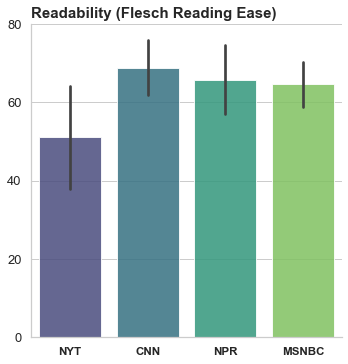

In [7]:
g = sns.catplot(data=df,
                x='cat', y='flesch_reading_ease', 
                ci='sd',
                kind='bar', 
                palette='viridis',
                alpha=.85)

plt.xlabel('')
plt.ylabel('')
g.set_xticklabels(['NYT', 'CNN', 'NPR', 'MSNBC'], fontweight='bold')
plt.yticks(range(0,100,20), size=13)
plt.title('Readability (Flesch Reading Ease)', fontweight='bold', loc='left', size=15)

save_mpl_fig(os.path.join(SAVEPATH, 'readability_nyt_cnn_npr_msnbc'))

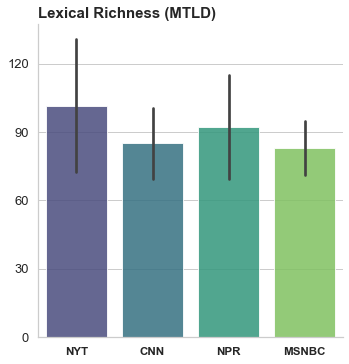

In [8]:
g = sns.catplot(data=df,
                x='cat', y='mtld', 
                ci='sd',
                kind='bar', 
                palette='viridis',
                alpha=.85)

plt.xlabel('')
plt.ylabel('')
g.set_xticklabels(['NYT', 'CNN', 'NPR', 'MSNBC'], fontweight='bold')
plt.yticks(range(0,140,30), size=13)
plt.title('Lexical Richness (MTLD)', fontweight='bold', loc='left', size=15)

save_mpl_fig(os.path.join(SAVEPATH, 'lexicalrichness_nyt_cnn_npr_msnbc'))